In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

/tmp/ipykernel_208810/1782326114.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = pd.read_csv('oasis_longitudinal.csv')

The dataset (https://www.kaggle.com/code/pranavplatti/detecting-early-alzheimer-s) сcomes from a study conducted on 150 patients some of which were diagnozed with dementia either at the beginning of the study or later in the study. The dataset includes various parameters of MRI images taken from the patients. Each of the patients was scanned at least once. The goal is to develop models that would be able to identify patients with dementia and pick the best performing model.

In [3]:
data.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


Exploratory analysis and preprocessing of the data

<Axes: xlabel='Group'>

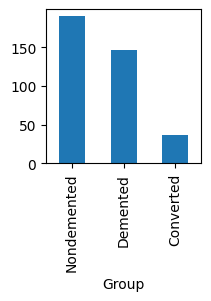

In [4]:
data.Group.value_counts().plot.bar(figsize=(2, 2))

In [5]:
data.Group = data.Group.apply(lambda x: 1 if x=='Nondemented' else 0)

Patients from the "converted" category eventually become demented, so they will be merged onto one group with patients from the "demented" category (group "0") for binary classification

Group
1    190
0    183
Name: count, dtype: int64

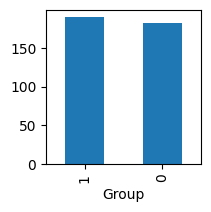

In [6]:
data.Group.value_counts().plot.bar(figsize=(2, 2))
data['Group'].value_counts()

In [7]:
to_drop = ['Subject ID', 'MRI ID']

In [8]:
data = data.drop(to_drop, axis = 1)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Group     373 non-null    int64  
 1   Visit     373 non-null    int64  
 2   MR Delay  373 non-null    int64  
 3   M/F       373 non-null    object 
 4   Hand      373 non-null    object 
 5   Age       373 non-null    int64  
 6   EDUC      373 non-null    int64  
 7   SES       354 non-null    float64
 8   MMSE      371 non-null    float64
 9   CDR       373 non-null    float64
 10  eTIV      373 non-null    int64  
 11  nWBV      373 non-null    float64
 12  ASF       373 non-null    float64
dtypes: float64(5), int64(6), object(2)
memory usage: 38.0+ KB


In [10]:
data.SES.unique()

array([ 2., nan,  3.,  4.,  1.,  5.])

In [11]:
data.MMSE.unique()

array([27., 30., 23., 28., 22., 29., 24., 21., 16., 25., 26., 15., 20.,
       19.,  7.,  4., 17., 18., nan])

In [12]:
data.SES = data.SES.transform(lambda x: x.fillna(x.median())).round(0)

In [13]:
data.MMSE = data.MMSE.transform(lambda x: x.fillna(x.median())).round(0)

In [14]:
data.head()

,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,1,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,0,1,0,M,R,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,0,2,560,M,R,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,0,3,1895,M,R,80,12,2.0,22.0,0.5,1698,0.701,1.034


In [15]:
le = LabelEncoder()

In [16]:
cs_2_tm = ['M/F', 'Hand']
data[cs_2_tm] = data[cs_2_tm].apply(le.fit_transform)

In [17]:
data.head()

,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1,1,0,1,0,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,1,2,457,1,0,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,0,1,0,1,0,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,0,2,560,1,0,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,0,3,1895,1,0,80,12,2.0,22.0,0.5,1698,0.701,1.034


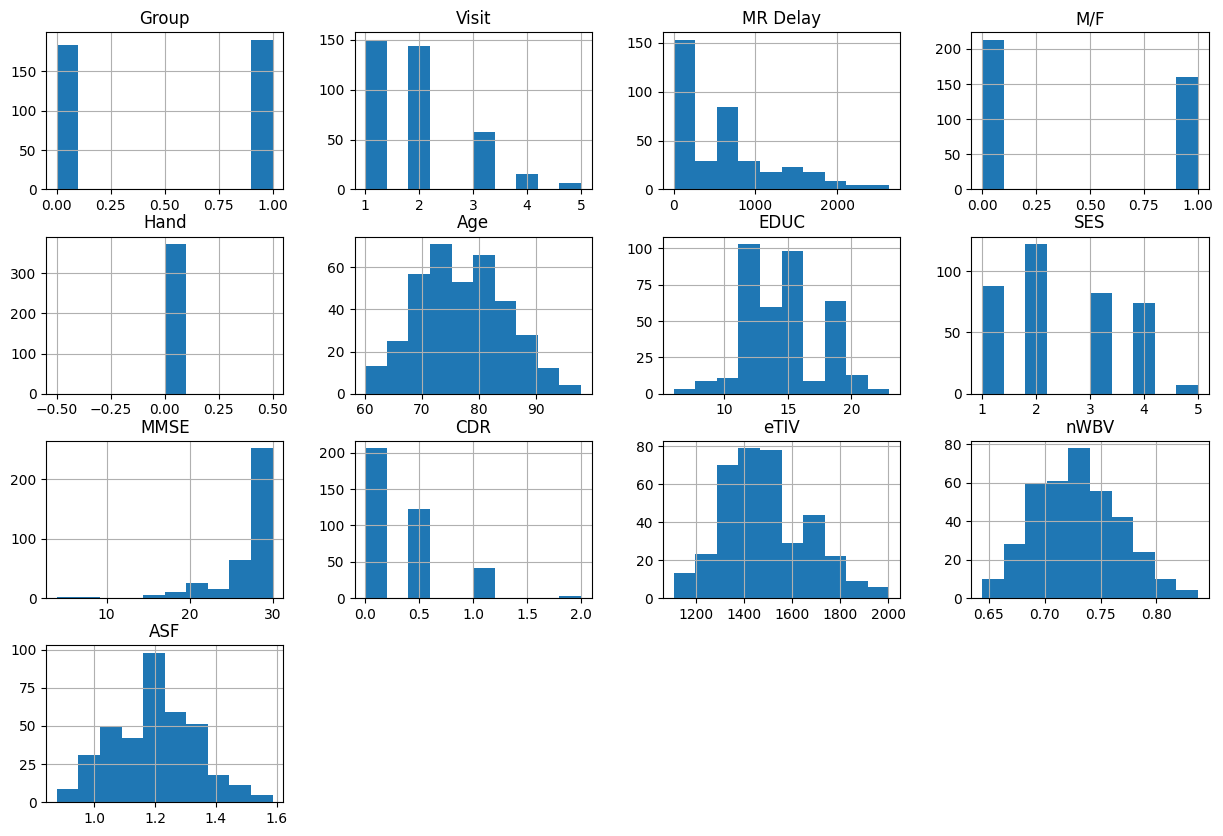

In [18]:
data.hist(figsize=(15, 10));

In [19]:
data['Hand'].unique()

array([0])

Looks like there are no left-handed people among the patients.

In [20]:
data = data.drop(['Hand'], axis = 1)

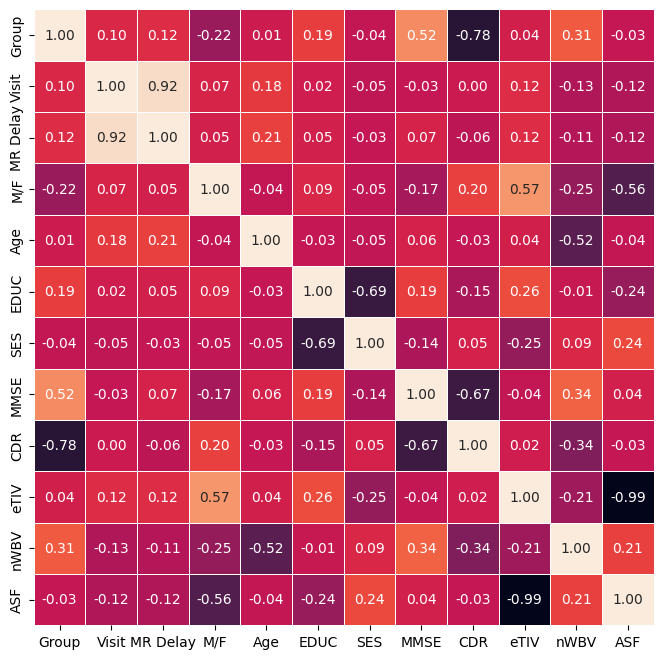

In [21]:
plt.figure(figsize=(8, 8))
sns.heatmap(data.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

CDR is Clinical Dementia Rating.

In [22]:
data['CDR'].unique()

array([0. , 0.5, 1. , 2. ])

Most likely all patients who have CDR = 0 are not demented.

In [23]:
data[data['Group'] == 1]['CDR'].values

array([0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

In [24]:
data[data['Group'] == 0]['CDR'].values

array([0.5, 0.5, 0.5, 0.5, 1. , 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 1. , 0.5,
       0.5, 0. , 0. , 0.5, 0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 1. , 0. , 0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0. , 0. , 0.5, 0.5, 0.5, 1. , 1. , 1. , 0.5, 1. ,
       1. , 1. , 1. , 1. , 1. , 0.5, 1. , 0. , 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 1. , 0.5, 0.5, 1. , 0.5, 1. , 1. , 0.5, 0.5, 0.5,
       1. , 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 1. , 2. , 1. , 1. , 0.5, 1. ,
       0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0. , 0.5, 0.5, 0.5,
       1. , 1. , 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1. ,
       0.5, 0.5, 0. , 0.5, 1. , 2. , 0.5, 0.5, 0. , 0.5, 0.5, 0.5, 0.5,
       0.5, 0. , 0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0. , 0.5, 0. , 0.5, 1. , 1. , 0.5, 1. , 1. , 1. , 0.5, 0.5, 0.5,
       1. , 0.5, 0.5, 1. , 2. , 1. , 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 0. ,
       0. , 0.5, 0.5, 0.5, 0.5, 1. , 1. , 0.5, 0.5, 0.5, 1. , 0.

Even though three patients who don't have dementia still have positive CDR, and several patients with dementia have CDR = 0, this feature will be excluded from the analysis. The CDR testing is generally used to assess the stage and progression of Alzheimer disease, thus, the results of the test are part of the diagnosis.

In [25]:
data = data.drop(['CDR'], axis = 1)

eTIV and ASF are Estimated Total Intracranial Volume and ASF is Atlas Scaling Factor which is an atlas-based head size normalization technique to measure the standardized total intracranial volume. These anatomical parameters are both estimates of intracranial volume, so one of them (eTIV) will go. The rest of the features will be included in the analysis.

In [26]:
data = data.drop(['eTIV'], axis = 1)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Group     373 non-null    int64  
 1   Visit     373 non-null    int64  
 2   MR Delay  373 non-null    int64  
 3   M/F       373 non-null    int64  
 4   Age       373 non-null    int64  
 5   EDUC      373 non-null    int64  
 6   SES       373 non-null    float64
 7   MMSE      373 non-null    float64
 8   nWBV      373 non-null    float64
 9   ASF       373 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 29.3 KB


For binary classification, several gradient boosting models will be trained: Gradient Boosting from sklearn, XGBoost, CatBoost, LightGBM.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Group'], axis=1), data['Group'], test_size=0.25, random_state=1,
stratify=data['Group'])

In [ ]:
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_f1 = f1_score(gb.predict(X_test), y_test)
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_f1 = f1_score(xgb.predict(X_test), y_test)
cb = CatBoostClassifier()
cb.fit(X_train, y_train)
cb_f1 = f1_score(cb.predict(X_test), y_test)

In [33]:
print('f1 score of models before tuning')
print(f'GradientBoosting: {gb_f1:.4f}')
print(f'XGboost: {xgb_f1:.4f}')
print(f'CatBoost: {cb_f1:.4f}')

f1 score of models before tuning
GradientBoosting: 0.8571
XGboost: 0.8800
CatBoost: 0.8738


XGBoost is the best performing model so far.

In [34]:
parameters = {'n_estimators': [50, 300, 500], 'max_features' : [None, 3], 'subsample' : [0, 0.5, 1], 'max_depth' : [3, 5, 10]}
model = GradientBoostingClassifier()
adj_model = GridSearchCV(model, parameters, scoring = 'f1')
adj_model.fit(X_train, y_train)
gb_adj = adj_model.predict(X_test)
print('Best parameters: ', adj_model.best_params_)

Best parameters:  {'max_depth': 10, 'max_features': None, 'n_estimators': 50, 'subsample': 0.5}


In [35]:
parameters = {'random_state' : [None, 1], 'warm_start' : [True, False], 'loss' : ['log_loss', 'exponential']}
model = GradientBoostingClassifier(max_depth=10, max_features=None, n_estimators=50, subsample=0.5)
adj_model = GridSearchCV(model, parameters, scoring = 'f1')
adj_model.fit(X_train, y_train)
gb_adj = adj_model.predict(X_test)
print('Best parameters: ', adj_model.best_params_)

Best parameters:  {'loss': 'exponential', 'random_state': None, 'warm_start': False}


In [36]:
parameters = {'n_estimators': [10, 300, 500], 'max_features' : [None, 3], 'subsample' : [0.05, 0.5, 1], 
              'max_depth' : [1, 5, 10]}
model = XGBClassifier()
adj_model = GridSearchCV(model, parameters, scoring = 'f1')
adj_model.fit(X_train, y_train)
xgb_adj = adj_model.predict(X_test)
print('Best parameters: ', adj_model.best_params_)

Best parameters:  {'max_depth': 10, 'max_features': None, 'n_estimators': 500, 'subsample': 1}


In [37]:
parameters = {'min_child_weight' : [0, 1, 5], 'learning_rate' : [0.01, 0.05, 0.1],
              'min_sample_leaf' : [1, 10, 50], 'random_state' : [None, 1]}
model = XGBClassifier(max_depth=10, max_features=None, n_estimators=500, subsample=1)
adj_model = GridSearchCV(model, parameters, scoring = 'f1')
adj_model.fit(X_train, y_train)
xgb_adj = adj_model.predict(X_test)
print('Best parameters: ', adj_model.best_params_)

Best parameters:  {'learning_rate': 0.05, 'min_child_weight': 0, 'min_sample_leaf': 1, 'random_state': None}


In [ ]:
parameters = {'iterations': [100, 500], 'depth' : [10, 50]}
model = CatBoostClassifier()
adj_model = GridSearchCV(model, parameters, scoring = 'f1')
adj_model.fit(X_train, y_train)
cb_adj = adj_model.predict(X_test)
print('Best parameters: ', adj_model.best_params_)

In [39]:
print('Best parameters: ', adj_model.best_params_)

Best parameters:  {'depth': 10, 'iterations': 500}


In [ ]:
parameters = {'learning_rate' : [0.1, 0.5], 'subsample' : [0.5, 1]}
model = CatBoostClassifier(depth=10, iterations=500)
adj_model = GridSearchCV(model, parameters, scoring = 'f1')
adj_model.fit(X_train, y_train)
cb_adj = adj_model.predict(X_test)
print('Best parameters: ', adj_model.best_params_)

In [41]:
print('Best parameters: ', adj_model.best_params_)

Best parameters:  {'learning_rate': 0.1, 'subsample': 0.5}


In [ ]:
parameters = {'colsample_bylevel': [0.1, 1], 'min_data_in_leaf' : [1, 50]}
model = CatBoostClassifier(depth=10, iterations=500, learning_rate=0.1, subsample=0.5)
adj_model = GridSearchCV(model, parameters, scoring = 'f1')
adj_model.fit(X_train, y_train)
cb_adj = adj_model.predict(X_test)
print('Best parameters: ', adj_model.best_params_)

In [43]:
print('Best parameters: ', adj_model.best_params_)

Best parameters:  {'colsample_bylevel': 1, 'min_data_in_leaf': 1}


In [44]:
print('f1 score of models after tuning:')
print(f'GB: {f1_score(gb_adj, y_test):.4f}')
print(f'XGBoost: {f1_score(xgb_adj, y_test):.4f}')
print(f'CatBoost: {f1_score(cb_adj, y_test):.4f}')

f1 score of models after tuning:
GB: 0.8491
XGBoost: 0.8627
CatBoost: 0.8571


The best performing model is XGBoost again.